In [1]:
import json
import os
from statsmodels.stats.contingency_tables import mcnemar
from collections import defaultdict
from tqdm import tqdm 
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
# Paths
# at the lab
# results_dir = os.path.abspath("../results/pairtest/classifier_results/")
# plots_dir = os.path.abspath("../../figures_and_tables")
# tables_dir = os.path.abspath("../../figures_and_tables")

# at home
results_dir = os.path.abspath("/Volumes/Elements/workspace/darth_linguo/results/pairtest/classifier_results/")
plots_dir = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/figures"
tables_dir = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/tables"


noisenames = {"AA":"adjectival agreement", "VA": "verbal agreement", "RV":"main verb removal"}

def build_contingency_table( first_table, second_table):
    yes_yes = 0
    yes_no = 0
    no_yes = 0
    no_no = 0
    if not first_table or not second_table:
        print("Warning, one of your experiments is empty, double check experiment names")
        return None
    if len(first_table) != len(second_table):
        print("Warning, tables are different lengths, please reevaluate,  your life")
        return None

    for first,second in zip(first_table, second_table):
        if first and second:
            yes_yes += 1
        elif not (first or second):
            no_no +=1
        elif first and not second:
            yes_no +=1
        elif second and not first:
            no_yes +=1
    contingency_table = [[yes_yes,yes_no],[no_yes,no_no]]
    return contingency_table




def convert_pairwise_to_df(pairwise, symmetric=True):
    #Converts a dictionary of single pairwise comparissons to a symmetric dataframe
    df = pd.DataFrame.from_dict(pairwise,orient='columns')
    if symmetric:
        for rowname, row in df.iterrows():
            for columname, value in row.iteritems():
                if columname == rowname:
                    df.loc[columname,rowname] = "-"
                elif np.isnan(value):
                    df.loc[rowname,columname] = df.loc[columname,rowname]
    return df

In [2]:
def calculate_mcnemmar(accuracy_tables):
    pvalue_df = {}
    mcnemar_df = {}
    contingency_tables ={}
    for noise_type in ["VA","AA","RV"]:
        pairwise_mcnemar = {name:{} for name in accuracy_tables[noise_type]}
        pairwise_p_value = {name:{} for name in accuracy_tables[noise_type]}
        experiment_names = sorted(list(accuracy_tables[noise_type]))
        for ind, first_experiment in tqdm(enumerate(experiment_names)):
            first_table = accuracy_tables[noise_type][first_experiment]
            pairwise_mcnemar[first_experiment][first_experiment] = "-"
            pairwise_p_value[first_experiment][first_experiment] = "-"
            for second_experiment in experiment_names[ind+1:]:
                second_table = accuracy_tables[noise_type][second_experiment]
                cont_table = build_contingency_table(first_table,second_table)
                if cont_table[0][1] + cont_table[1][0] < 25:
                    stats_result = mcnemar(cont_table, exact=True)
                    print("Comparisson between {} and {} has less than 25 disagreement".format(first_experiment,second_experiment))
                if cont_table[0][1] + cont_table[1][0]:
                    stats_result = mcnemar(cont_table, exact=False, correction=True)
                pairwise_mcnemar[first_experiment][second_experiment] = stats_result.statistic
                pairwise_p_value[first_experiment][second_experiment] = stats_result.pvalue
        pvalue_df[noise_type] = convert_pairwise_to_df(pairwise_p_value)
        mcnemar_df[noise_type] = convert_pairwise_to_df(pairwise_mcnemar) 
    return pvalue_df, mcnemar_df

In [3]:
def calculate_pair_accuracy(prediction_filename):
    gram = []
    ugram = []
    accuracy_list = []
    correct_count = 0
    with open(prediction_filename,"r") as pred_file:
        for line in pred_file:
            item = json.loads(line)
            if item["gold_label"] == "grammatical":
                gram.append(item)
            else:
                ugram.append(item)
    assert len(gram)==len(ugram),f"Error in file {prediction_filename}, there are {len(gram)} grammatical versions and {len(ugram)} ungrammatical ones." 
    for original,corrupt in zip(gram,ugram):
        if (original["predicted_label"] == "grammatical"
                and corrupt["predicted_label"] == "ungrammatical"):
            correct_count += 1
            accuracy_list.append(True)
        else:
            accuracy_list.append(False)

    return correct_count/len(accuracy_list), accuracy_list
# test_filename = "/home/lab/Pablo/darth_linguo/results/pairtest/classifier_results/exp-1.2_pretrained-freeze_AA_results"
# this_accuracy, this_list = calculate_pair_accuracy(test_filename)

In [4]:
def load_pairtest_results(target_folder, experiment_prefix):
    noise_types = ["AA","RV","VA"]
    accuracy_tables = {ntype:defaultdict(list) for ntype in noise_types}
    accuracy_numbers = {ntype:{} for ntype in noise_types}
    accuracy_G = {ntype:{} for ntype in noise_types}
    accuracy_U = {ntype:{} for ntype in noise_types}
    pvalue_df = {}
    mcnemar_df = {}
    cond_num = 0
    for filename in tqdm(os.listdir(target_folder)):
        fullpath = os.path.join(target_folder, filename)
        results = []
        if not os.path.isdir(fullpath):
            parameters = filename.split("_") 
            exp_id = parameters[0]
            condition = parameters[1]
            exp_name = "_".join(parameters[0:-2])
            noise_type = parameters[-2]

            if exp_id == experiment_prefix:
                accuracy, correct_table = calculate_pair_accuracy(fullpath)
                accuracy_numbers[noise_type][condition] = accuracy
                accuracy_tables[noise_type][condition] = correct_table
                cond_num +=1
    message = "Finished loading data, {} conditions loaded from experiment {}".format(cond_num, experiment_prefix)
    print(message)
    return accuracy_numbers, accuracy_tables

In [5]:

def build_relative_table(original_ordered_conds, all_accuracies,all_p_values, baseline):
    latex_table = """\\begin{table}[ht]
	\\centering
	\\begin{tabular}"""
    #set the number of columns
    ordered_conds = original_ordered_conds[:]
    ordered_conds.remove(baseline)
    cols="{"+"|c"*(len(ordered_conds)+1)+"|}\n\t\hline"
    latex_table+=cols
    #define the colors
    highsigni_color="YellowGreen"
    lowsigni_color = "Dandelion"
    unsigni_color="myOrange"
    # Build the header
    
    header = " &"+"&".join(ordered_conds)+ "\t\\\\\n\hline\n\t"
    latex_table+= header
    for ug_type in all_accuracies:
        latex_cells = []
        latex_cells.append(ug_type)
        accuracies = all_accuracies[ug_type]
        p_values = all_p_values[ug_type]
        for this_condition in ordered_conds:
            pval = p_values.loc[baseline,this_condition]
            if pval<=0.001:
                color = highsigni_color
            elif pval <=0.05:
                color = lowsigni_color
            else:
                color=unsigni_color                
            value = ((accuracies[this_condition] - accuracies[baseline])/accuracies[baseline]) * 100
            this_cell = "{{\cellcolor{{{color}}}}}{value:+.2g}\%".format(color=color,
                                                                    value=value)
            latex_cells.append(this_cell)
        row="&".join(latex_cells)+ "\\\\\n"
        latex_table+=row
        latex_table+="\t\\hline\n\t"
    latex_table += """	\end{tabular} 
        \caption{}
    \end{table}"""
    return latex_table





In [6]:
import matplotlib.pyplot as plt

def build_latex_accuracies_table(accuracy_numbers, ordered_conds=None, cond_to_name=None):
    columns = ["AA","VA","RV"]
    rows = {}
    if cond_to_name is None:
        cond_to_name = {name:name for name in ordered_conds}
        
    for field in columns:
        for condition in accuracy_numbers[field]:
            if condition not in rows:
                rows[condition] = {}
            rows[condition][field] = accuracy_numbers[field][condition]
    print(rows)
    # build the actual table
    latex_table = """\\begin{table}[ht]
	\\centering
	\\begin{tabular}"""
    #set the number of columns
    if not ordered_conds:
        ordered_conds = list(rows)
    cols="{"+"|c"*(len(columns)+1)+"|}\hline\n\t"
    latex_table+=cols
    # Build the header
    header = " &"+"&".join(columns)+ "\\\\\hline\n\t"
    latex_table+= header
    print(ordered_conds)
    for cond in ordered_conds:
        latex_cells = []
        latex_cells.append(cond_to_name[cond])
        for col in columns:
            value = rows[cond][col] 
            this_cell = "{value:.3g}\%".format(value=value)
            latex_cells.append(this_cell)
        row="&".join(latex_cells)+ "\\\\\\hline\n\t"
        latex_table+=row
    latex_table += """	\end{tabular} 
        \caption{}
    \end{{table}}"""
    return latex_table




def build_2layer_bar_plot(accuracy_G,accuracy_U,
                          ordered_conds,x_label,
                         title,target_experiment,
                          cond_to_name=None
                         ):
    if cond_to_name is None:
        cond_to_name = {name:name for name in ordered_conds}
    print(ordered_conds)
    #Graph with the G and U accuracies . overimposed 
    AAG_numbers = [ accuracy_G['AA'][cond_to_name[cond]] for cond in ordered_conds ]
    AAU_numbers = [ accuracy_U['AA'][cond_to_name[cond]] for cond in ordered_conds ]

    VAG_numbers = [ accuracy_G['VA'][cond_to_name[cond]] for cond in ordered_conds ]
    VAU_numbers = [ accuracy_U['VA'][cond_to_name[cond]] for cond in ordered_conds ]

    RVG_numbers = [ accuracy_G['RV'][cond_to_name[cond]] for cond in ordered_conds]
    RVU_numbers = [ accuracy_U['RV'][cond_to_name[cond]] for cond in ordered_conds]

    ind = np.arange(len(accuracy['AA']))
    width = 0.25

    fig, ax = plt.subplots()
    #Make the rectangles
    AAG_rects = ax.bar(ind - width, AAG_numbers, width,
                   color="#ed845e",
                  label= "Adj Agreement (gram)")
    AAU_rects = ax.bar(ind - width, AAU_numbers, width,
                   color="#c1471b",
                  label= "Adj Agreement (ungram)",)

    VAG_rects = ax.bar(ind, VAG_numbers, width,
                   color="skyblue",
                  label= "Verb Agreement (gram)")
    VAU_rects = ax.bar(ind, VAU_numbers, width,
                   color="steelblue",
                  label= "Verbal Agreement (ungram)")

    RVG_rects = ax.bar(ind + width, RVG_numbers, width,
                   color="#a7ce90",
                  label= "Verb Removal (gram)")
    RVU_rects = ax.bar(ind + width, RVU_numbers, width,
                   color="#658752",
                  label= "Verb Removal (ungram)")

    # Add the labels
    ax.set_axisbelow(True)
    ax.grid(which='major',axis='y',alpha=0.8,color='black')

    ax.set_ylabel("Accuracy")
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(ordered_conds, rotation='45')
    ax.set_ylim(bottom=0.5)

    lgd = plt.legend(bbox_to_anchor=(1.03, 0.45), loc=2, borderaxespad=0.)
    plt.show
    plt.savefig(os.path.join(plots_dir,target_experiment.replace(".","-")+"_UandGaccuracies.png")
               ,bbox_extra_artists=(lgd,), bbox_inches='tight')
    
def build_bar_plot(accuracy,ordered_conds,x_label,
                         title,target_experiment, cond_to_name=None,
                         legend_y_offset=0, label_rotation=45):
    if cond_to_name is None:
        cond_to_name = {name:name for name in ordered_conds}
    #print(ordered_conds)
    #Graph with the G and U accuracies . overimposed 
    AA_numbers = [ accuracy['AA'][cond_to_name[cond]] for cond in ordered_conds ]
    
    VA_numbers = [ accuracy['VA'][cond_to_name[cond]] for cond in ordered_conds ]
    
    RV_numbers = [ accuracy['RV'][cond_to_name[cond]] for cond in ordered_conds]
    
    ind = np.arange(len(accuracy['AA']))
    width = 0.25

    fig, ax = plt.subplots()
    #Make the rectangles
    AA_rects = ax.bar(ind - width, AA_numbers, width,
                   color="#c1471b",
                  label= "Adj Agreement")
    
    VA_rects = ax.bar(ind, VA_numbers, width,
                   color="steelblue",
                  label= "Verb Agreement")
    
    RV_rects = ax.bar(ind + width, RV_numbers, width,
                   color="#658752",
                  label= "Verb Removal")

    # Add the labels
    ax.set_axisbelow(True)
    ax.grid(which='major',axis='y',alpha=0.8,color='black')

    ax.set_ylabel("Accuracy")
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(ordered_conds, rotation=label_rotation)
    ax.set_ylim(bottom=0.5)

    lgd = plt.legend(bbox_to_anchor=(0.5, legend_y_offset), loc="lower center", ncol=3)
    plt.show
    plot_file=os.path.join(plots_dir,target_experiment.replace(".","-")+"_pair_accuracies.png")
    plt.savefig(plot_file
               ,bbox_extra_artists=(lgd,), bbox_inches='tight')
    print("Plot saved to:{}".format(plot_file))

In [ ]:
# For experiment 1.1
target_experiment_base = "exp-1.1"
try:
    len(accuracy_numbers_base)
except NameError:
    accuracy_numbers_base, accuracy_tables_base = load_pairtest_results(results_dir, target_experiment_base)
ordered_conds_base = ["32-32", "64-64", "128-128", "256-256", "512-512", "512-1024"]
table_folder = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/tables"
table_folder = tables_dir
title = "Sentence pair Accuracy by model dimensions"
x_label = "Embeddings dimension - Hidden dimension"

build_bar_plot(accuracy_numbers_base,ordered_conds_base,x_label,title,target_experiment_base, legend_y_offset=-.4)
print(build_latex_accuracies_table(accuracy_numbers_base, ordered_conds=ordered_conds_base))



In [ ]:
# For experiment embeddings behavior (1.2)
target_experiment_embs = "exp-1.2"
try:
    len(accuracy_numbers_embs)
except NameError:
    accuracy_numbers_embs, accuracy_tables_embs = load_pairtest_results(results_dir, target_experiment_embs)

ordered_conds_embs = ["random","pretrained-cont","pretrained-freeze"]
    
baseline = "random"
#table_folder = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/tables"
table_folder = tables_dir
#caption = "The relative difference in accuracy by embedding dimension on {} data, green indicates that the difference in error proportions highly significant ($p\\leq 0.001$), orange that it is significant($0.001\\leq p \\leq 0.05$), red that it is not significant, according to Mc Nemar's test. ".format(noisenames[noise_type])
#relative_table = build_relative_table(ordered_conds, accuracy_numbers, pvalue_df, baseline, caption)
#with open(os.path.join(table_folder,"exp-1.2_relative.tex".format(noise_type)),"w") as outfile:
        #outfile.write(relative_table)
title = "Sentence pair Accuracy by embedding behaviour"
x_label = "Embeddings behavior"
    
build_bar_plot(accuracy_numbers_embs,ordered_conds_embs,x_label, title, target_experiment_embs)
print(build_latex_accuracies_table(accuracy_numbers_embs, ordered_conds=ordered_conds_embs))

p_values_embs, mc_nem_embs = calculate_mcnemmar(accuracy_tables_embs)

print(build_relative_table(ordered_conds_embs, accuracy_numbers_embs,p_values_embs, "random"))

In [ ]:
p_values_embs['AA']


In [ ]:
build_contingency_table(accuracy_tables_embs['AA']['random'],accuracy_tables_embs['AA']['pretrained-freeze'])

In [ ]:
# For experiment 1.3
target_experiment_emsbsize="exp-1.3"
try:
    len(accuracy_numbers_emsbsize)
except NameError:
    accuracy_numbers_emsbsize, accuracy_tables_emsbsize = load_pairtest_results(results_dir, target_experiment_emsbsize)

ordered_conds_emsbsize = ["16-512","32-512","64-512","128-512","256-512","512-512"]
    
baseline = "random"
#table_folder = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/tables"
table_folder = tables_dir
#caption = "The relative difference in accuracy by embedding dimension on {} data, green indicates that the difference in error proportions highly significant ($p\\leq 0.001$), orange that it is significant($0.001\\leq p \\leq 0.05$), red that it is not significant, according to Mc Nemar's test. ".format(noisenames[noise_type])
#relative_table = build_relative_table(ordered_conds, accuracy_numbers, pvalue_df, baseline, caption)
#with open(os.path.join(table_folder,"exp-1.2_relative.tex".format(noise_type)),"w") as outfile:
        #outfile.write(relative_table)
title = "Sentence pair Accuracy by embedding dimension"
x_label = "Model dimensions (E-H)"
    
build_bar_plot(accuracy_numbers_emsbsize,ordered_conds_emsbsize,x_label, title, target_experiment_emsbsize)
print(build_latex_accuracies_table(accuracy_numbers_emsbsize, ordered_conds=ordered_conds_emsbsize))

In [ ]:
# For experiment 2.1

cond_name_to_code_lstm = {'unidirectional\n 1 layer':'1uni-1-layer',
                     'unidirectional\n 2 layers':'2uni-2-layer',
                     'unidirectional\n 3 layers':'3uni-3-layer',
                     'bidirectional\n 1 layer':'4bi-1-layer',
                     'bidirectional\n 2 layers':'5bi-2-layer',
                     'bidirectional\n 3 layers':'6bi-3-layer'}

cond_code_to_name_lstm = {code : name for name,code in cond_name_to_code_lstm.items()}

ordered_conds_lstm = ['1uni-1-layer',
                     '2uni-2-layer',
                     '3uni-3-layer',
                     '4bi-1-layer',
                     '5bi-2-layer',
                     '6bi-3-layer' ]

ordered_conds_names_lstm = ['unidirectional\n 1 layer',
                'unidirectional\n 2 layers',
                'unidirectional\n 3 layers',
                'bidirectional\n 1 layer',
                'bidirectional\n 2 layers',
                'bidirectional\n 3 layers']


target_experiment_lstm="exp-2.1"
try:
    len(accuracy_numbers_lstm)
except NameError:
    accuracy_numbers_lstm, accuracy_tables_lstm = load_pairtest_results(results_dir, target_experiment_lstm)


# for noise_type in noise_types:
#     ordered_conds= ['unidirectional\n 1 layer',
# 'unidirectional\n 2 layers',
# 'unidirectional\n 3 layers',
# 'bidirectional\n 1 layer',
# 'bidirectional\n 2 layers',
# 'bidirectional\n 3 layers']
#     caption = "The relative difference in accuracy between LSTM architectures on {} data, green indicates that the difference in error proportions highly significant ($p\\leq 0.001$), orange that it is significant($0.001\\leq p \\leq 0.05$), red that it is not significant, according to Mc Nemar's test. ".format(noisenames[noise_type])
#     table_latex = build_LATEX_pairwise_table(cond_code_to_name.values(), accuracy_U[noise_type], pvalue_df[noise_type], caption )
#     table_folder = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/tables"
#     with open(os.path.join(table_folder,"{}_{}_pairwise.tex".format(target_experiment,noise_type)),"w") as outfile:
#         outfile.write(table_latex)

# for noise_type in noise_types:
#     caption = "Pairwise p-value accross LSTM architectures on {} data, green indicates that the difference in error proportions highly significant ($p\\leq 0.001$), orange that it is significant($0.001\\leq p \\leq 0.05$), red that it is not significant, according to Mc Nemar's test. ".format(noisenames[noise_type])
#     table_latex = build_pvalues_table(cond_code_to_name.values(), pvalue_df[noise_type], caption )
#     table_folder = "/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/tables"
#     with open(os.path.join(table_folder,"{}_{}_pvals.tex".format(target_experiment,noise_type)),"w") as outfile:
#         outfile.write(table_latex)

title = "Accuracy by LSTM architecture"
x_label = "LSTM architecture"

# build_2layer_bar_plot(accuracy_G,accuracy_U,
#                       ordered_conds,x_label,
#                      title,cond_to_name=cond_code_to_name)

# baseline="1uni-1-layer"
# relative_table = build_relative_table(list(cond_code_to_name.values()), accuracy_numbers, pvalue_df, baseline, caption)
# with open(os.path.join(table_folder,"exp-2.1_relative.tex".format(noise_type)),"w") as outfile:
#         outfile.write(relative_table)
    
build_bar_plot(accuracy_numbers_lstm,ordered_conds_names_lstm,x_label, title, target_experiment_lstm, cond_to_name=cond_name_to_code_lstm, legend_y_offset=-0.5, label_rotation=45)
print(build_latex_accuracies_table(accuracy_numbers_lstm, ordered_conds=ordered_conds_lstm, cond_to_name=cond_code_to_name_lstm))


In [7]:
def load_dual_cond_results(target_folder, experiment_prefix):
    noise_types = ["AA","RV","VA"]
    accuracy_tables = defaultdict(lambda : defaultdict(lambda : defaultdict(list)))
    accuracy_numbers = defaultdict(lambda : defaultdict(lambda : defaultdict(int)))
    accuracy_G = {ntype:{} for ntype in noise_types}
    accuracy_U = {ntype:{} for ntype in noise_types}
    pvalue_df = {}
    mcnemar_df = {}
    cond_num = 0
    for filename in tqdm(os.listdir(target_folder)):
        fullpath = os.path.join(target_folder, filename)
        results = []
        if not os.path.isdir(fullpath):
            parameters = filename.split("_") 
            exp_id = parameters[0]
            condition = parameters[1]
            dimensions = parameters[2]
            exp_name = "_".join(parameters[0:-2])
            noise_type = parameters[-2]

            if exp_id == experiment_prefix:
                accuracy, correct_table = calculate_pair_accuracy(fullpath)
                accuracy_numbers[dimensions][noise_type][condition] = accuracy
                accuracy_tables[dimensions][noise_type][condition] = correct_table
                cond_num +=1
    message = "Finished loading data, {} conditions loaded from experiment {}".format(cond_num, experiment_prefix)
    print(message)
    return accuracy_numbers, accuracy_tables

100%|██████████| 256/256 [04:26<00:00,  2.75s/it]


Finished loading data, 90 conditions loaded from experiment exp-3
Plot saved to:/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/figures/exp-3128-128_pair_accuracies.png
Plot saved to:/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/figures/exp-332-32_pair_accuracies.png
Plot saved to:/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/figures/exp-332-64_pair_accuracies.png
Plot saved to:/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/figures/exp-364-128_pair_accuracies.png
Plot saved to:/Users/pablo/Dropbox/Universidad/Thesis/Dissertation/Results/figures/exp-364-64_pair_accuracies.png


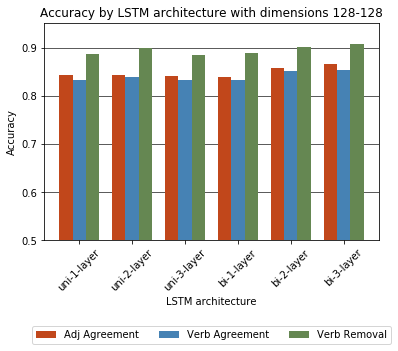

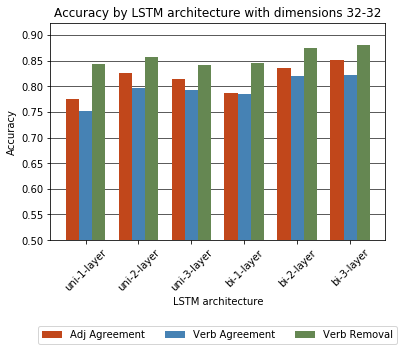

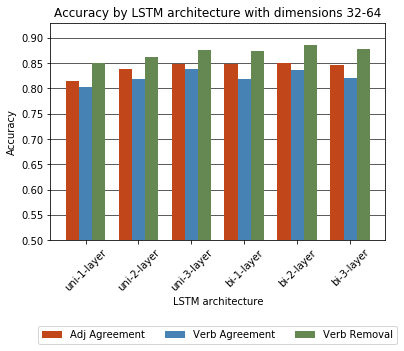

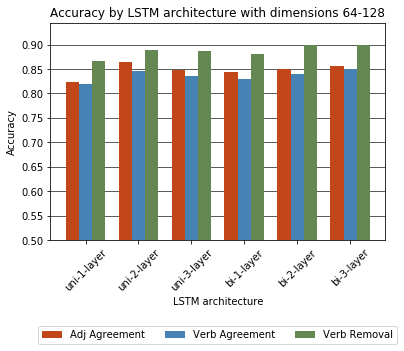

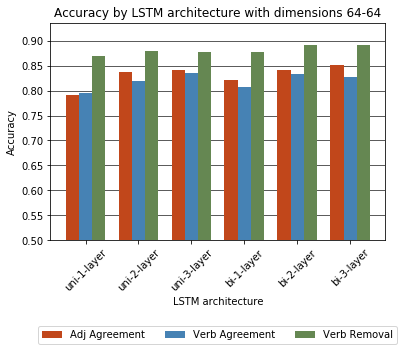

In [8]:
# For experiment 3 (deeper on lower dimensions)

target_experiment_embs = "exp-3"
ordered_conds_minilstm = ['uni-1-layer',
                               'uni-2-layer',
                               'uni-3-layer',
                               'bi-1-layer',
                               'bi-2-layer',
                               'bi-3-layer']
try:
    len(accuracy_numbers_minilstm)
except NameError:
    accuracy_numbers_minilstm, accuracy_tables_minilstm = load_dual_cond_results(results_dir, target_experiment_embs)
    
# build_bar_plot(accuracy_numbers_lstm,,x_label, title, target_experiment_lstm, legend_y_offset=-0.5, label_rotation=45)
for dimensionality in accuracy_numbers_minilstm:
    numbers = accuracy_numbers_minilstm[dimensionality]
    title = "Accuracy by LSTM architecture with dimensions {}".format(dimensionality) 
    x_label = "LSTM architecture"
    build_bar_plot(numbers,ordered_conds_minilstm,x_label, title, target_experiment_embs + dimensionality, legend_y_offset=-0.5, label_rotation=45)


In [34]:
import csv

minilstm_res_path = "/Users/pablo/Dropbox/workspace/darth_linguo/results/consolidated/minilstm.csv"
modelwise_dict = defaultdict(lambda: defaultdict(int))
for dimensionality in accuracy_numbers_minilstm:
    for noise in accuracy_numbers_minilstm[dimensionality]:
        for lstm_type in accuracy_numbers_minilstm[dimensionality][noise]:
            model_name = "{}_{}".format(dimensionality,lstm_type)
            modelwise_dict[model_name][noise] = accuracy_numbers_minilstm[dimensionality][noise][lstm_type]
            
res_df =  pd.DataFrame.from_dict(modelwise_dict,orient="index")

sent_nums = {}
for noise_type in ["VA","AA","RV"]:
    sent_nums[noise_type] = len (accuracy_tables_minilstm["128-128"][noise_type]["uni-1-layer"])

for exp in res_df.index:
    total_acuracy = sum([res_df.loc[exp, noise] * sent_nums[noise] for noise in sent_nums])/ sum([num for num in sent_nums.values()])
    res_df.loc[exp,'total'] = total_acuracy

res_df.to_csv(minilstm_res_path)

In [35]:
res_df

,VA,AA,RV,total
128-128_bi-1-layer,0.833447,0.839751,0.889385,0.855763
128-128_bi-2-layer,0.851041,0.856984,0.900758,0.871008
128-128_bi-3-layer,0.854028,0.865693,0.906932,0.877369
128-128_uni-1-layer,0.833120,0.843913,0.886194,0.856180
128-128_uni-2-layer,0.839999,0.843826,0.898860,0.862380
128-128_uni-3-layer,0.832147,0.840479,0.885569,0.854365
32-32_bi-1-layer,0.785590,0.787675,0.845158,0.807539
32-32_bi-2-layer,0.820450,0.835627,0.875303,0.845859
32-32_bi-3-layer,0.821567,0.851012,0.879971,0.853831
32-32_uni-1-layer,0.750739,0.774362,0.842545,0.792569


In [33]:
exp = '128-128_bi-1-layer'
print(res_df.loc['128-128_bi-1-layer'])
total_acuracy = sum([res_df.loc[exp, noise] * sent_nums[noise] for noise in sent_nums])/ sum([num for num in sent_nums.values()])
print(sent_nums)

VA       0.833447
AA       0.839751
RV       0.889385
total    0.855763
Name: 128-128_bi-1-layer, dtype: float64
{'VA': 103787, 'AA': 160744, 'RV': 145432}


In [32]:
res_df

,VA,AA,RV,total
128-128_bi-1-layer,0.833447,0.839751,0.889385,0.855763
128-128_bi-2-layer,0.851041,0.856984,0.900758,0.871008
128-128_bi-3-layer,0.854028,0.865693,0.906932,0.877369
128-128_uni-1-layer,0.833120,0.843913,0.886194,0.856180
128-128_uni-2-layer,0.839999,0.843826,0.898860,0.862380
128-128_uni-3-layer,0.832147,0.840479,0.885569,0.854365
32-32_bi-1-layer,0.785590,0.787675,0.845158,0.807539
32-32_bi-2-layer,0.820450,0.835627,0.875303,0.845859
32-32_bi-3-layer,0.821567,0.851012,0.879971,0.853831
32-32_uni-1-layer,0.750739,0.774362,0.842545,0.792569


In [ ]:
# Build contingency table and test for single comparison
trial = build_contingency_table(accuracy_tables["VA"]["exp-1.1_128-128"], 
                        accuracy_tables["VA"]["exp-1.1_128-128"])

result = mcnemar(trial, exact=False, correction=True)
print('statistic={}, p-value={}'.format(result.statistic, result.pvalue))